# 基于经典网络架构训练图像分类模型
- 数据预处理
- 网络模块设置
- 网络模块保存与测试

In [17]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

torch.__version__

'2.4.1+cu118'

### 数据读取与预处理操作

In [18]:
data_dir = '../data/flower_data/'
train_dir = data_dir + 'train'
valid_dir = data_dir + 'valid'

### 制作好数据源

In [19]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),  #随机旋转，-45到45度之间随机选
                                 transforms.CenterCrop(224),  #从中心开始裁剪
                                 transforms.RandomHorizontalFlip(p=0.5),  #随机水平翻转 选择一个概率概率
                                 transforms.RandomVerticalFlip(p=0.5),  #随机垂直翻转
                                 transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
                                 #参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
                                 transforms.RandomGrayscale(p=0.025),  #概率转换成灰度率，3通道就是R=G=B
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #均值，标准差
                                 ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
}

In [20]:
batch_size = 8

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, str(x)), data_transforms[x]) for x in
                  ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [21]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ../data/flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ../data/flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0

In [22]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2780ae070a0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x2780ae06680>}

In [23]:
dataset_sizes

{'train': 6552, 'valid': 818}

### 读取标签对应的实际名字

In [24]:
with open(f'{data_dir}cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 展示数据
- 注意tensor的数据需要转换成numpy的格式，而且还需要还原回标准化的结果

In [25]:
# 展示数据
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

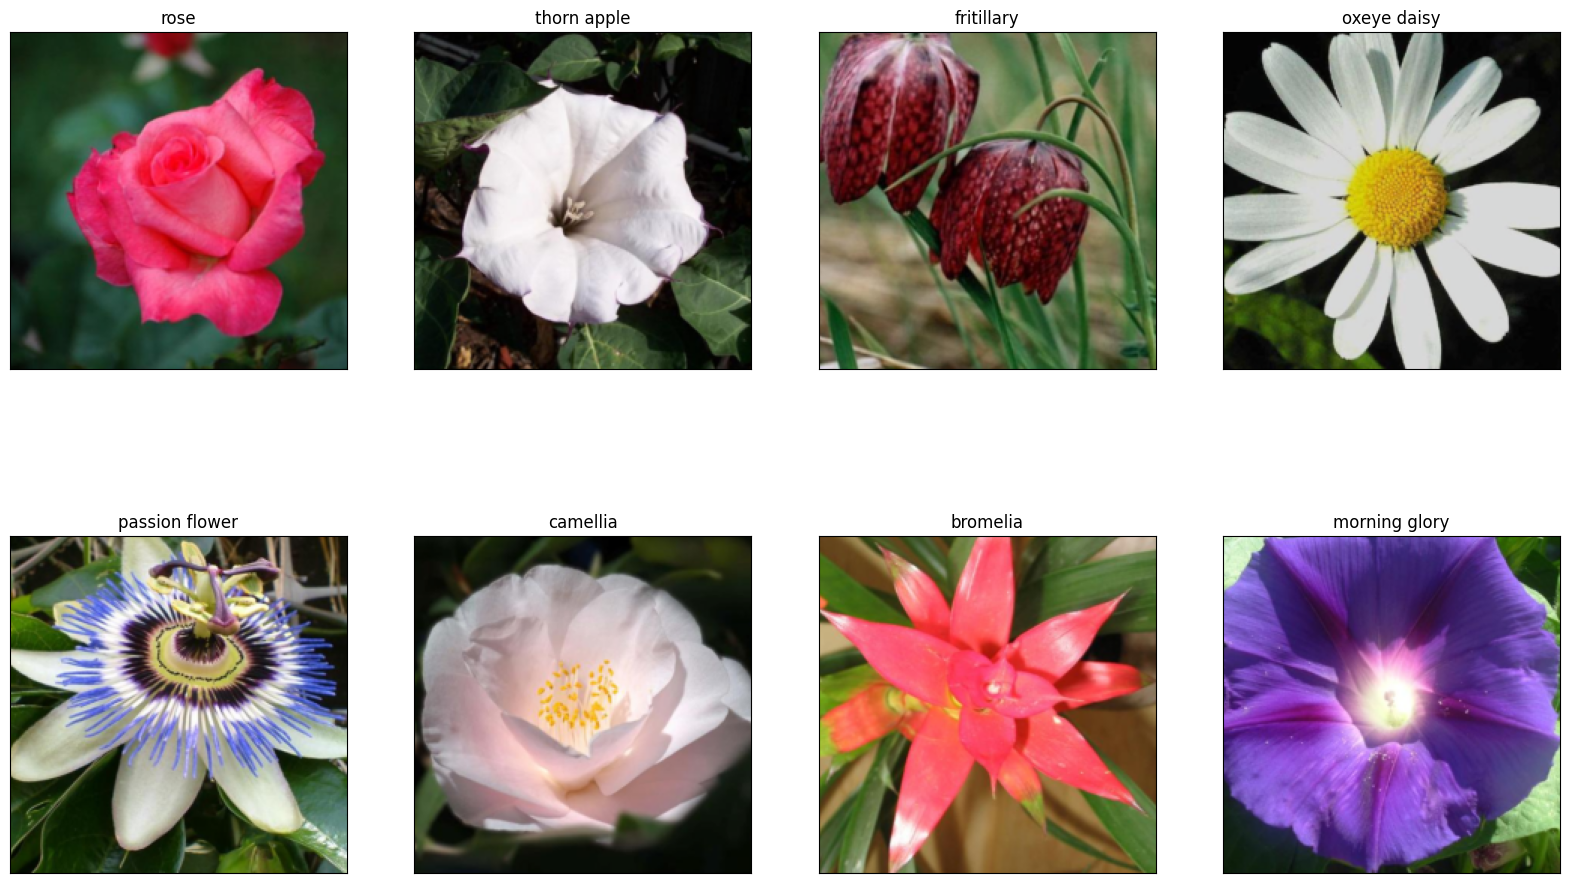

In [30]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.__next__()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()